## Computational ressources

In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 

cluster.scale(102) 

from dask.distributed import Client
client = Client(cluster)

client

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://172.30.100.4:33619 Dashboard: http://172.30.100.4:33263/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7473749      allc make_pro albert7a PD       0:00      1 (None)
           7473750      allc make_pro albert7a PD       0:00      1 (None)
           7473751      allc make_pro albert7a PD       0:00      1 (None)
           7473752      allc make_pro albert7a PD       0:00      1 (None)


## Librairies and customization

In [3]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


## Localisation of the region

In [4]:
data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
tfilename = sorted(glob.glob(data_dir+'*/eNATL60-BLBT02_1h_*_gridT-2D_20090701-20090701.nc'))
filename =tfilename[0]


In [5]:
%time ds=xr.open_dataset(filename)['sossheig']


CPU times: user 42 ms, sys: 44.4 ms, total: 86.4 ms
Wall time: 1.32 s


In [6]:
ds

<xarray.DataArray 'sossheig' (time_counter: 24, y: 4729, x: 8354)>
[948145584 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-01T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [7]:
print(ds.nbytes/1e9)

3.792582336


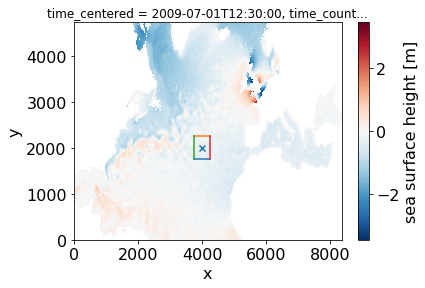

In [8]:
ds[12].plot()
plt.plot([3750, 4250], [1750, 1750])
plt.plot([3750, 4250], [2250, 2250])
plt.plot([3750, 3750], [1750, 2250])
plt.plot([4250, 4250], [1750, 2250])
plt.scatter(4000,2000,marker='x')

## Importing the data : SSH in run eNATL60-BLBT02 for FMA months at location X

In [5]:
tfilenames_FMA = []

for month in ['02','03','04']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_FMA=tfilenames_FMA+tfilenames_month

In [ ]:
%time dsFMA=xr.open_mfdataset(tfilenames_FMA,chunks={'x':1000,'y':1000,'time_counter':1})['sossheig']


In [15]:
dsFMA

<xarray.DataArray 'sossheig' (time_counter: 2136, y: 4729, x: 8354)>
dask.array<shape=(2136, 4729, 8354), dtype=float32, chunksize=(1, 1000, 1000)>
Coordinates:
    nav_lat        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nav_lon        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2136,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-30T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [19]:
print(dsFMA.nbytes/1e9)

337.539827904


In [ ]:
dsFMA_reg=dsFMA[:,1750:2250,3750:4250].chunk({'x':1,'y':1,'time_counter':2136})

In [18]:
print(dsFMA_reg.nbytes/1e9)

2.136


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


CPU times: user 4min 18s, sys: 24.6 s, total: 4min 43s
Wall time: 4min 31s


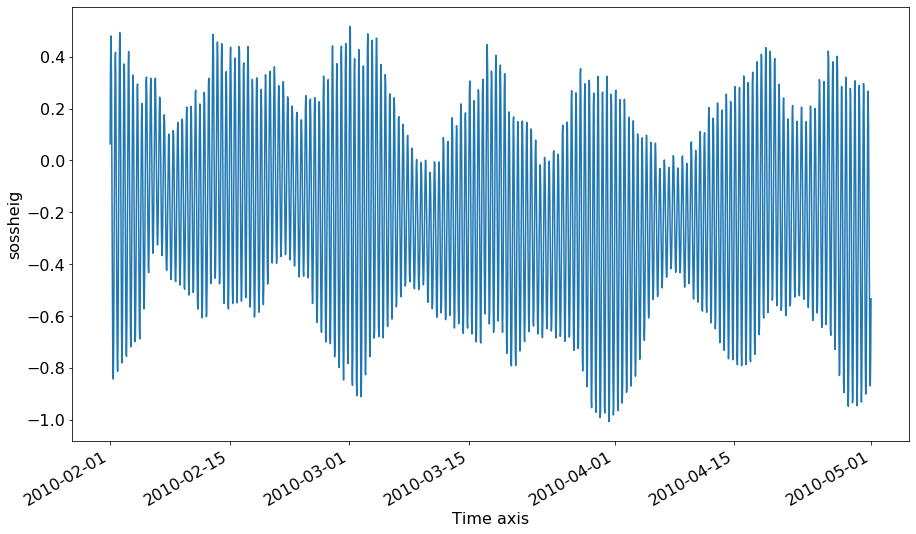

In [24]:
%time dsFMA_reg.mean(dim={'x','y'}).plot()

In [ ]:
tfilenames_ASO = []

for month in ['08','09','10']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_ASO=tfilenames_ASO+tfilenames_month

In [ ]:
%time dsASO=xr.open_mfdataset(tfilenames_ASO,chunks={'x':1000,'y':1000,'time_counter':1})['sossheig']
    

In [ ]:
dsASO_reg=dsASO[:,1750:2250,3750:4250].chunk({'x':1,'y':1,'time_counter':2136})

## FFT decomposition and power spectral density computation

In [ ]:
NPADDING = 2
SPtime_FMA_reg = xfft.fft(dsFMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=dsFMA_reg.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 

SPtime_ASO_reg = xfft.fft(dsASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=dsASO.shape[0]*NPADDING,tapering=True)
MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


In [ ]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH in the box')